In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import plot_tree



In [2]:
# load the dataset
df = pd.read_csv('data/churn_dataset.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
# Rename columns with '_' instead of spaces
df.columns = df.columns.str.replace(' ','_')

# Drop the phone number column.
# df.drop('phone_number', axis=1, inplace=True)
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

In [4]:
#Perfoming label encoding
#False becomes 0 and True becomes 1
encoder = LabelEncoder()
df['churn'] = encoder.fit_transform(df['churn'])


In [5]:
df.drop('phone_number', axis=1, inplace=True)

In [6]:
df.drop('state', axis=1, inplace=True)
df.drop('area_code', axis=1, inplace=True)

In [7]:
#Performing label encoding
#No becomes 0 and yes becomes 1.
df['international_plan'] = encoder.fit_transform(df['international_plan'])



In [8]:
df.drop(labels=['number_vmail_messages','voice_mail_plan', 'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge'],
       axis=1,
       inplace=True)
df.head()

,account_length,international_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,customer_service_calls,churn
0,128,0,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,0,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,84,1,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,75,1,166.7,113,148.3,122,186.9,121,10.1,3,3,0


In [9]:
#Excluding total international minutes
highly_correlated_variables = df[['international_plan', 'total_day_minutes', 'total_eve_minutes', 'total_intl_minutes', 'customer_service_calls', 'churn']]
highly_correlated_variables.head()

,international_plan,total_day_minutes,total_eve_minutes,total_intl_minutes,customer_service_calls,churn
0,0,265.1,197.4,10.0,1,0
1,0,161.6,195.5,13.7,1,0
2,0,243.4,121.2,12.2,0,0
3,1,299.4,61.9,6.6,2,0
4,1,166.7,148.3,10.1,3,0


In [10]:
# Define X and y, and split train/test data
df_copy = highly_correlated_variables.copy()

X = df_copy.drop(columns=['churn'],axis=1)
y = df_copy['churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=7,stratify=y)

In [11]:
# Print original class distribution
print('Original Class Distribution: \n')
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

# Preview new class distribution
print('------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

Original Class Distribution: 

0    2137
1     362
Name: churn, dtype: int64
------------------------------
Synthetic sample class distribution: 

1    2137
0    2137
Name: churn, dtype: int64


In [12]:
# Define the parameters to search
tree_params = {
    'max_depth': list(range(1, 20)),
    'min_samples_split': list(range(2, 11)),  # Values from 2 to 10
    'min_samples_leaf': list(range(1, 5)),  # Values from 1 to 4
    'max_features': list(range(1, X.shape[1] + 1)),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

# Create a DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)

# Create GridSearchCV object
clf = GridSearchCV(dtc, tree_params, cv=5, scoring='recall', return_train_score=True)

# Fit the model
clf.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found
print("Best Parameters:", clf.best_params_)

# Print the best score found
print("Best Recall Score:", clf.best_score_)

# Print the best score std
print("Best Recall Score STD:", clf.best_score_)


Best Parameters: {'criterion': 'gini', 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best Recall Score: 0.9405830725119833
Best Recall Score STD: 0.9405830725119833


In [13]:
cv_results = clf.cv_results_

In [14]:
mean_train_scores = cv_results['mean_train_score'][clf.best_index_]
std_train_scores = cv_results['std_train_score'][clf.best_index_]
mean_test_scores = cv_results['mean_test_score'][clf.best_index_]
std_test_scores = cv_results['std_test_score'][clf.best_index_]

In [15]:
# Print or use the mean and standard deviation scores as needed
print("Mean Train Scores:", mean_train_scores)
print("Standard Deviation Train Scores:", std_train_scores)
print("Mean Test Scores:", mean_test_scores)
print("Standard Deviation Test Scores:", std_test_scores)


Mean Train Scores: 0.9460651042468665
Standard Deviation Train Scores: 0.022619321587267694
Mean Test Scores: 0.9405830725119833
Standard Deviation Test Scores: 0.027754269062832945


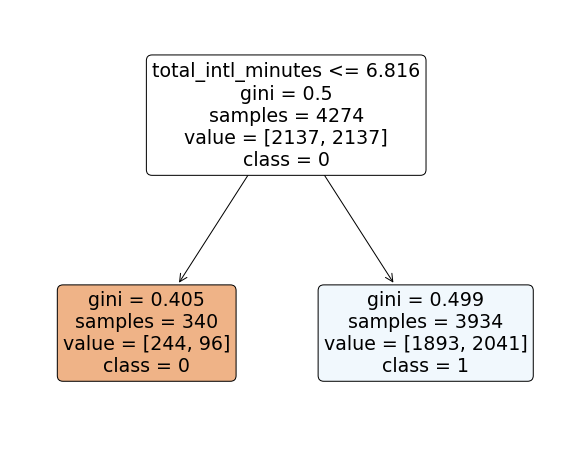

In [16]:
# Plot the decision tree of the best model
best_model = clf.best_estimator_
plt.figure(figsize=(10, 8))
plot_tree(best_model, filled=True, rounded=True, class_names=['0', '1'], feature_names=X.columns)
plt.show()

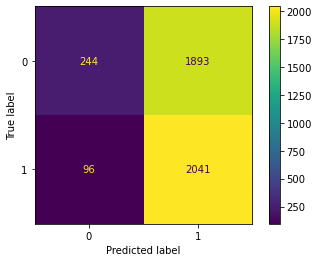

In [18]:
# Generate confusion matrix directly from estimator
ConfusionMatrixDisplay.from_estimator(best_model, X_train_resampled, y_train_resampled, display_labels=['0', '1']);

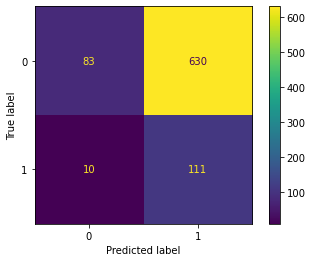

In [19]:
##Runnning TEST

# Generate confusion matrix directly from estimator
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['0', '1']);
#REcall of .7851

In [21]:
from sklearn.metrics import recall_score, classification_report

# Make predictions on test data
y_pred_test = best_model.predict(X_test)

# Calculate recall
recall_test = recall_score(y_test, y_pred_test)

print("Recall on test data:", recall_test)


Recall on test data: 0.9173553719008265


In [22]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.12      0.21       713
           1       0.15      0.92      0.26       121

    accuracy                           0.23       834
   macro avg       0.52      0.52      0.23       834
weighted avg       0.78      0.23      0.21       834

